<a href="https://colab.research.google.com/github/afroman32/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Classification_Metrics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
from sklearn.model_selection import train_test_split
# split train data into train and val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
import numpy as np
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent copy warning
    X = X.copy()
    
    # change low latitude and longitude to zeros
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # replace null values with zero
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop unnecessary columns
    unnecessary = ['quantity_group', 'payment_type', 'recorded_by', 'id']
    X = X.drop(columns = unnecessary)
    
    # convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # get year, and month from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month

    # drop the date_recorded column
    X = X.drop(columns='date_recorded')
    
    # years between concstuction and inspection
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

# run function for train, val, and test
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# set target
target = 'status_group'

# use all columns except target as features
columns = list(train.columns)
columns.remove('status_group')
features = columns

# set X matrices and y vectors
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [0]:
%%time
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

# Fit on training set
pipeline.fit(X_train, y_train)

# score on validation set
print(f'Validation Accuracy: {pipeline.score(X_val, y_val)}')

Validation Accuracy: 0.811026936026936
CPU times: user 22.2 s, sys: 325 ms, total: 22.5 s
Wall time: 12.4 s


In [0]:
import sklearn
sklearn.__version__

'0.22.1'

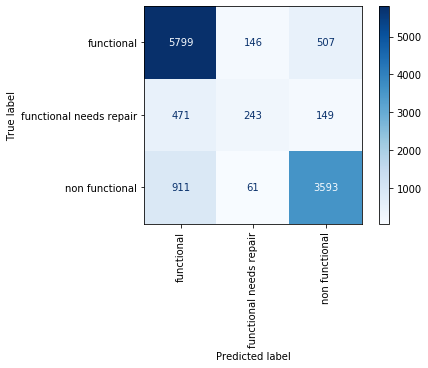

In [0]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline,
                      X_val, y_val,
                      values_format='.0f',
                      xticks_rotation='vertical',
                      cmap = 'Blues');